# Import

In [1]:
import rpy2
import rpy2.robjects as ro 
from rpy2.robjects.vectors import FloatVector 
from rpy2.robjects.packages import importr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import torch
import itstgcn
import random

/home/csy/anaconda3/envs/temp_csy/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def save_data(data_dict,fname):
    with open(fname,'wb') as outfile:
        pickle.dump(data_dict,outfile)

In [3]:
def load_data(fname):
    with open(fname, 'rb') as outfile:
        data_dict = pickle.load(outfile)
    return data_dict

# GNAR Data copy

In [4]:
%load_ext rpy2.ipython

In [5]:
%%R
library(GNAR)
library(igraph)

- edge(list)
- dist(list)

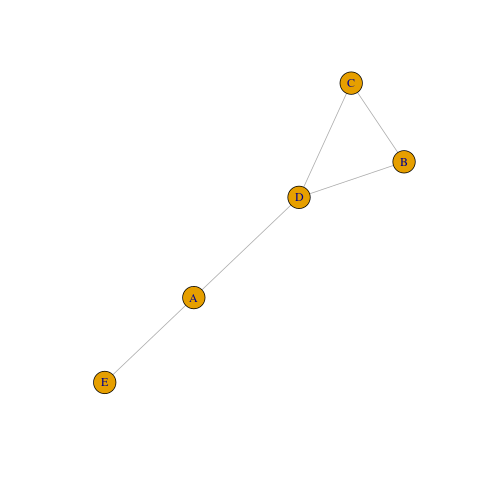

In [6]:
%%R
plot(fiveNet, vertex.label = c("A", "B", "C", "D", "E"))

In [7]:
%%R
as.matrix(fiveNet)

     [,1] [,2] [,3] [,4] [,5]
[1,]    0    0    0    1    1
[2,]    0    0    1    1    0
[3,]    0    1    0    1    0
[4,]    1    1    1    0    0
[5,]    1    0    0    0    0


In [8]:
%%R
data("fiveNode")
answer <- GNARfit(vts = fiveVTS, net = fiveNet, alphaOrder = 2, betaOrder = c(1, 1))
answer

Model: 
GNAR(2,[1,1]) 

Call:
lm(formula = yvec ~ dmat + 0)

Coefficients:
 dmatalpha1  dmatbeta1.1   dmatalpha2  dmatbeta2.1  
    0.20624      0.50277      0.02124     -0.09523  



$$X_{i,t} = \sum^p_{j=1}\big( \alpha_{i,j} X_{i,t-j} + \sum^C_{c=1} \sum^{s_j}_{r=1} \beta_{j,r,c} \sum_{1 \in \cal{N}^{(r)}_t (i)} \omega^{(t)}_{i,q,c} X_{q,t-j} \big) + u_{i,t}$$

- $p \in \mathbb{N}$ is the maximum time lag
- $[s] = (s_1, \dots , s_p)$ and $s_j \in \mathbb{N}_0$ is the maximum stage of neighbor dependence for time lag $j$, with $\mathbb{N}_0 = \mathbb{N} \cup \{ 0\}$
- $\cal{N}^{(r)}_t (i)$ is the $r$th stage neighbour set of node $i$ at time $t$
- $\omega^{(t)}_{i,q,c} \in [0,1]$ is the connection weight between node $i$ and node $q$ at time $t$ if the path corresponds to covariate $c$

$$X_{A,t} = 0.206 X_{A,t−1}+0.503 (X_{E,t−1}+X_{D,t−1})/2+0.021 X_{A,t−2}−0.095(X_{E,t−2}+X_{D,t−2})/2+u_{A,t}$$

$$X_{B,t} = 0.206 X_{B,t−1}+0.503 (X_{C,t−1}+X_{D,t−1})/2+0.021 X_{B,t−2}−0.095(X_{C,t−2}+X_{D,t−2})/2+u_{B,t}$$

$$X_{C,t} = 0.206 X_{C,t−1}+0.503 (X_{B,t−1}+X_{D,t−1})/2+0.021 X_{C,t−2}−0.095(X_{B,t−2}+X_{D,t−2})/2+u_{C,t}$$

$$X_{D,t} = 0.206 X_{D,t−1}+0.503 (X_{A,t−1}+X_{B,t−1}+X_{C,t−1})/3+0.021 X_{D,t−2}−0.095(X_{A,t−1}+X_{B,t−1}+X_{C,t−1})/3+u_{D,t}$$

$$X_{E,t} = 0.206 X_{E,t−1}+0.503 (X_{A,t−1})+0.021 X_{E,t−2}−0.095(X_{A,t−1})+u_{E,t}$$

In [9]:
from statsmodels.tsa.arima.model import ARIMA

https://communities.sas.com/t5/SAS-Tech-Tip/SAS-%ED%99%9C%EC%9A%A9-%EB%85%B8%ED%95%98%EC%9A%B0-%EC%8B%9C%EA%B3%84%EC%97%B4-AR-1-%EA%B3%BC-AR-2/ta-p/792106

In [10]:
a_ylag1 = np.random.normal(size=1)
a_ylag2 = np.random.normal(size=1)

In [11]:
b_ylag1 = np.random.normal(size=1)
b_ylag2 = np.random.normal(size=1)

In [12]:
# alpha1 = 0.206
alpha1 = 0.25
alpha2 = 0.2
# alpha2 = 0.01
# beta1 = 0.503
beta1 = 0.02
beta2 = -0.01
a_ar_values = []
a_ar_values_true = []
b_ar_values = []
b_ar_values_true = []

In [13]:
for i in range(500):
    a_e = np.random.normal(size=1) * 0.2
    b_e = np.random.normal(size=1) * 0.2
    
    # a_y = alpha1 * a_ylag1 + alpha2 * a_ylag2 + a_e + beta1 * (e_ylag1 + d_ylag1) / 2 + beta2 * (e_ylag2 + d_ylag2) / 2
    # b_y = alpha1 * b_ylag1 + alpha2 * b_ylag2 + b_e + beta1 * (c_ylag1 + d_ylag1) / 2 + beta2 * (c_ylag2 + d_ylag2) / 2
    # c_y = alpha1 * c_ylag1 + alpha2 * c_ylag2 + c_e + beta1 * (b_ylag1 + d_ylag1) / 2 + beta2 * (b_ylag2 + d_ylag2) / 2
    # d_y = alpha1 * d_ylag1 + alpha2 * d_ylag2 + d_e + beta1 * (a_ylag1 + b_ylag1 + c_ylag1) / 3 + beta2 * (a_ylag2 + b_ylag2 + c_ylag2) / 3
    # e_y = alpha1 * e_ylag1 + alpha2 * e_ylag2 + e_e + beta1 * a_ylag1 + beta2 * a_ylag2
    a_y_true = alpha1 * a_ylag1 + alpha2 * a_ylag2 + beta1 * (b_ylag1) + beta2 * (a_ylag2)
    a_y = a_y_true + a_e
    b_y_true = alpha1 * b_ylag1 + alpha2 * b_ylag2 + beta1 * (a_ylag1) + beta2 * (b_ylag2)
    b_y = b_y_true + b_e
    
    a_ar_values_true.append(a_y_true[0])
    a_ar_values.append(a_y[0])
    b_ar_values_true.append(b_y_true[0])
    b_ar_values.append(b_y[0])
    
    a_ylag2 = a_ylag1
    b_ylag2 = b_ylag1
    
    a_ylag1 = a_y
    b_ylag1 = b_y

In [14]:
np.sum(a_ar_values)

-3.2711566556232894

In [15]:
np.sum(b_ar_values)

-2.1112465923067365

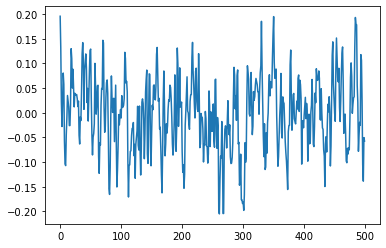

In [16]:
plt.plot(a_ar_values_true)

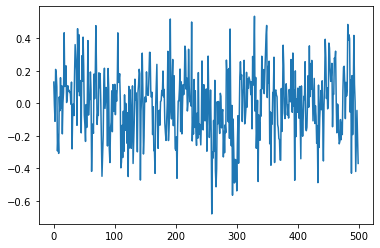

In [17]:
plt.plot(a_ar_values)

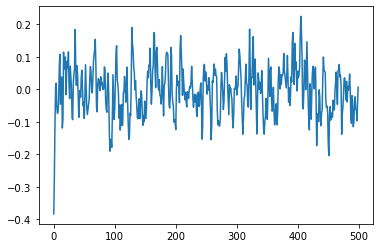

In [18]:
plt.plot(b_ar_values_true)

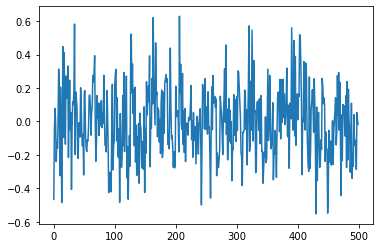

In [19]:
plt.plot(b_ar_values)

In [20]:
df = {'A' : a_ar_values, 'B' : b_ar_values}

In [21]:
_node_ids = {'node1':0, 'node2':1}

In [22]:
_edges = torch.tensor([[0,1],[1,0]]).tolist()

In [23]:
_FX1 = np.stack([a_ar_values,b_ar_values],axis=1).tolist()

In [24]:
data_dict = {'edges':_edges, 'node_ids':_node_ids, 'FX':_FX1}

In [25]:
save_data(data_dict,'toy_ex_dataset.pkl')

# Random

In [26]:
data_dict = load_data('toy_ex_dataset.pkl')

In [27]:
loader = itstgcn.DatasetLoader(data_dict)

In [28]:
dataset = loader.get_dataset(lags=2)

In [29]:
train_dataset, test_dataset = itstgcn.temporal_signal_split(dataset, train_ratio=0.8)

In [30]:
mindex_rand = itstgcn.rand_mindex(train_dataset,mrate=0.7)

/home/csy/Dropbox/blog/posts/GCN/itstgcn/utils.py:71: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343998658/work/torch/csrc/utils/tensor_new.cpp:245.)
  lags = torch.tensor(train_dataset.features).shape[-1]


In [31]:
train_dataset_miss_rand = itstgcn.miss(train_dataset,mindex_rand,mtype='rand')

In [32]:
train_dataset_padded_rand = itstgcn.padding(train_dataset_miss_rand) # padding(train_dataset_miss,method='linear'와 같음)

`-` 학습

In [33]:
lrnr_rand = itstgcn.StgcnLearner(train_dataset_padded_rand)

In [34]:
lrnr_rand.learn(filters=32,epoch=50)

In [35]:
lrnr_rand_it = itstgcn.ITStgcnLearner(train_dataset_padded_rand)

In [36]:
lrnr_rand_it.learn(filters=32,epoch=50)

`-` 모형 평가 및 시각화

In [37]:
evtor_rand = itstgcn.Evaluator(lrnr_rand,train_dataset_padded_rand,test_dataset)

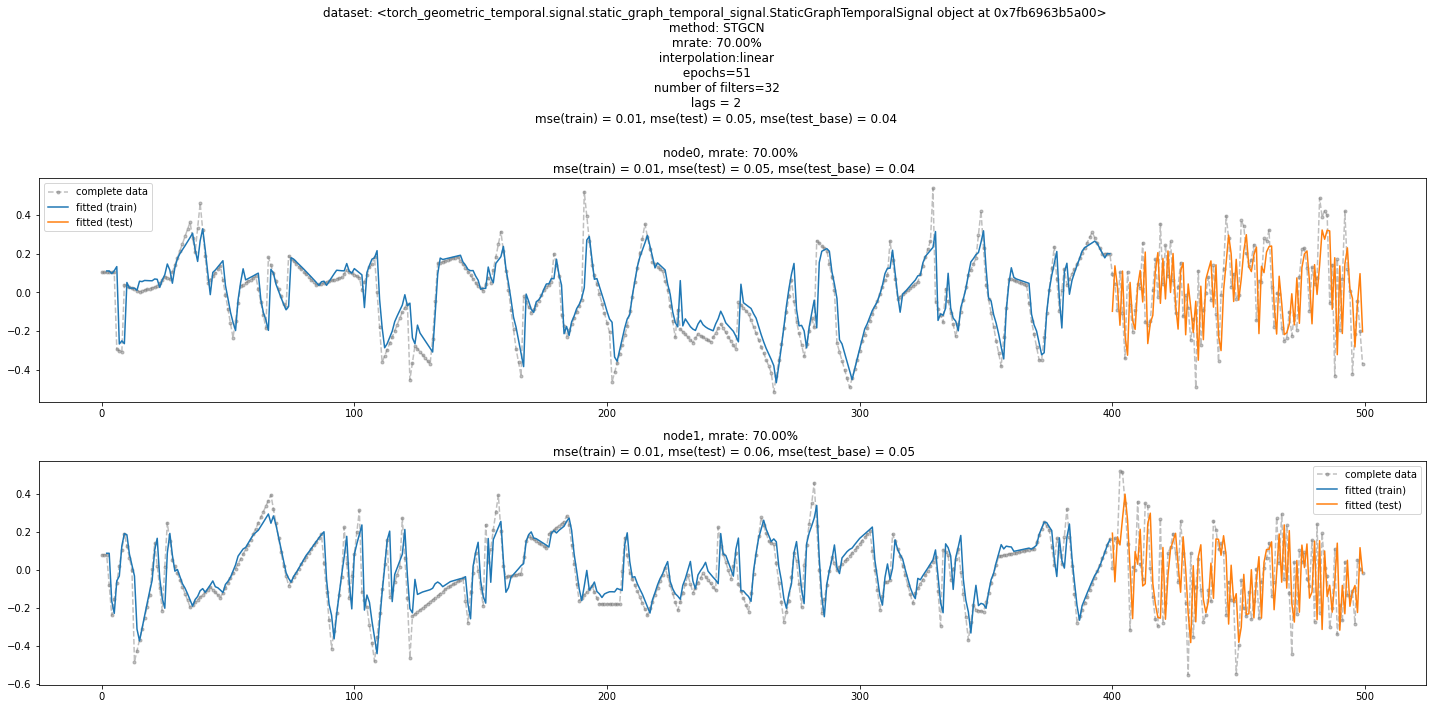

In [38]:
fig = evtor_rand.plot('--.',h=5,max_node=2,label='complete data',alpha=0.5) # max_nodes 는 1보다 커야함
fig.set_figwidth(20)
fig.set_figheight(10)
fig.tight_layout()
fig

In [39]:
evtor_rand_it = itstgcn.Evaluator(lrnr_rand_it,train_dataset_padded_rand,test_dataset)

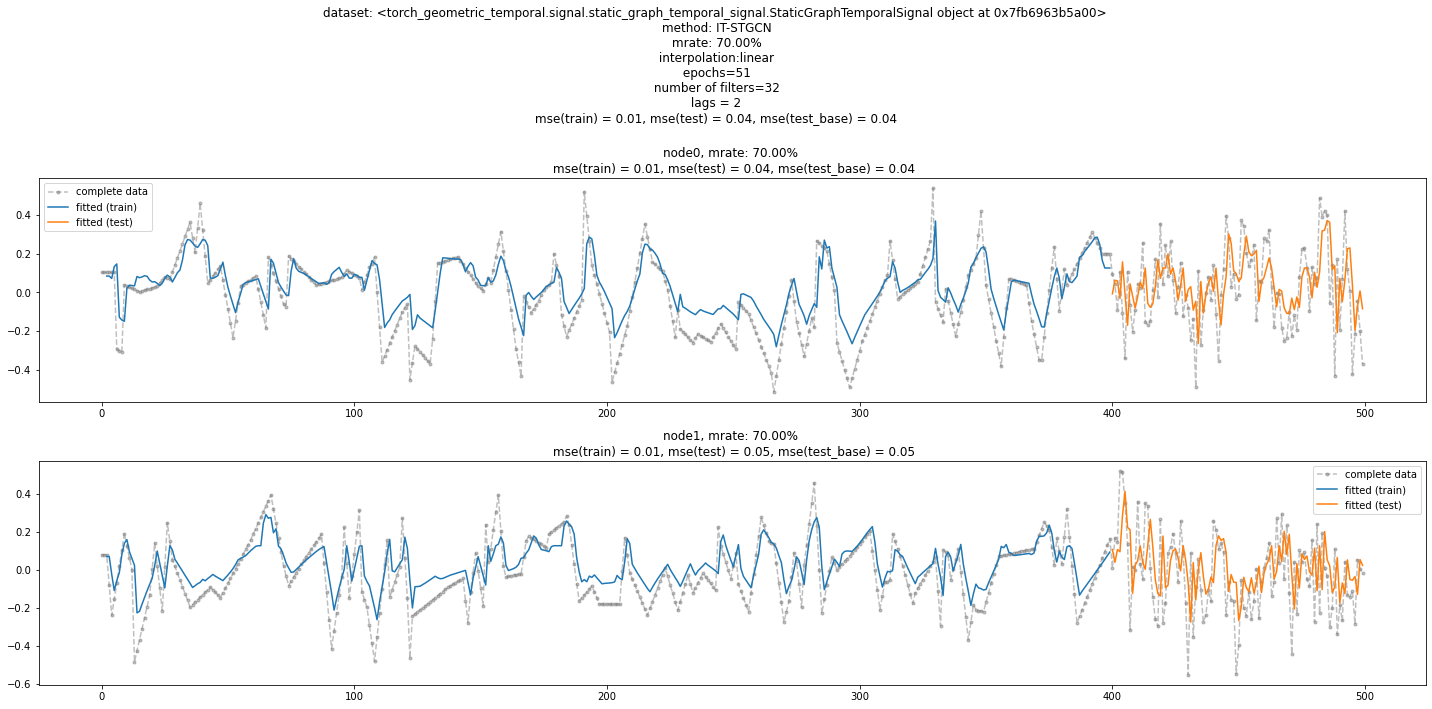

In [40]:
fig = evtor_rand_it.plot('--.',h=5,max_node=2,label='complete data',alpha=0.5) # max_nodes 는 1보다 커야함
fig.set_figwidth(20)
fig.set_figheight(10)
fig.tight_layout()
fig

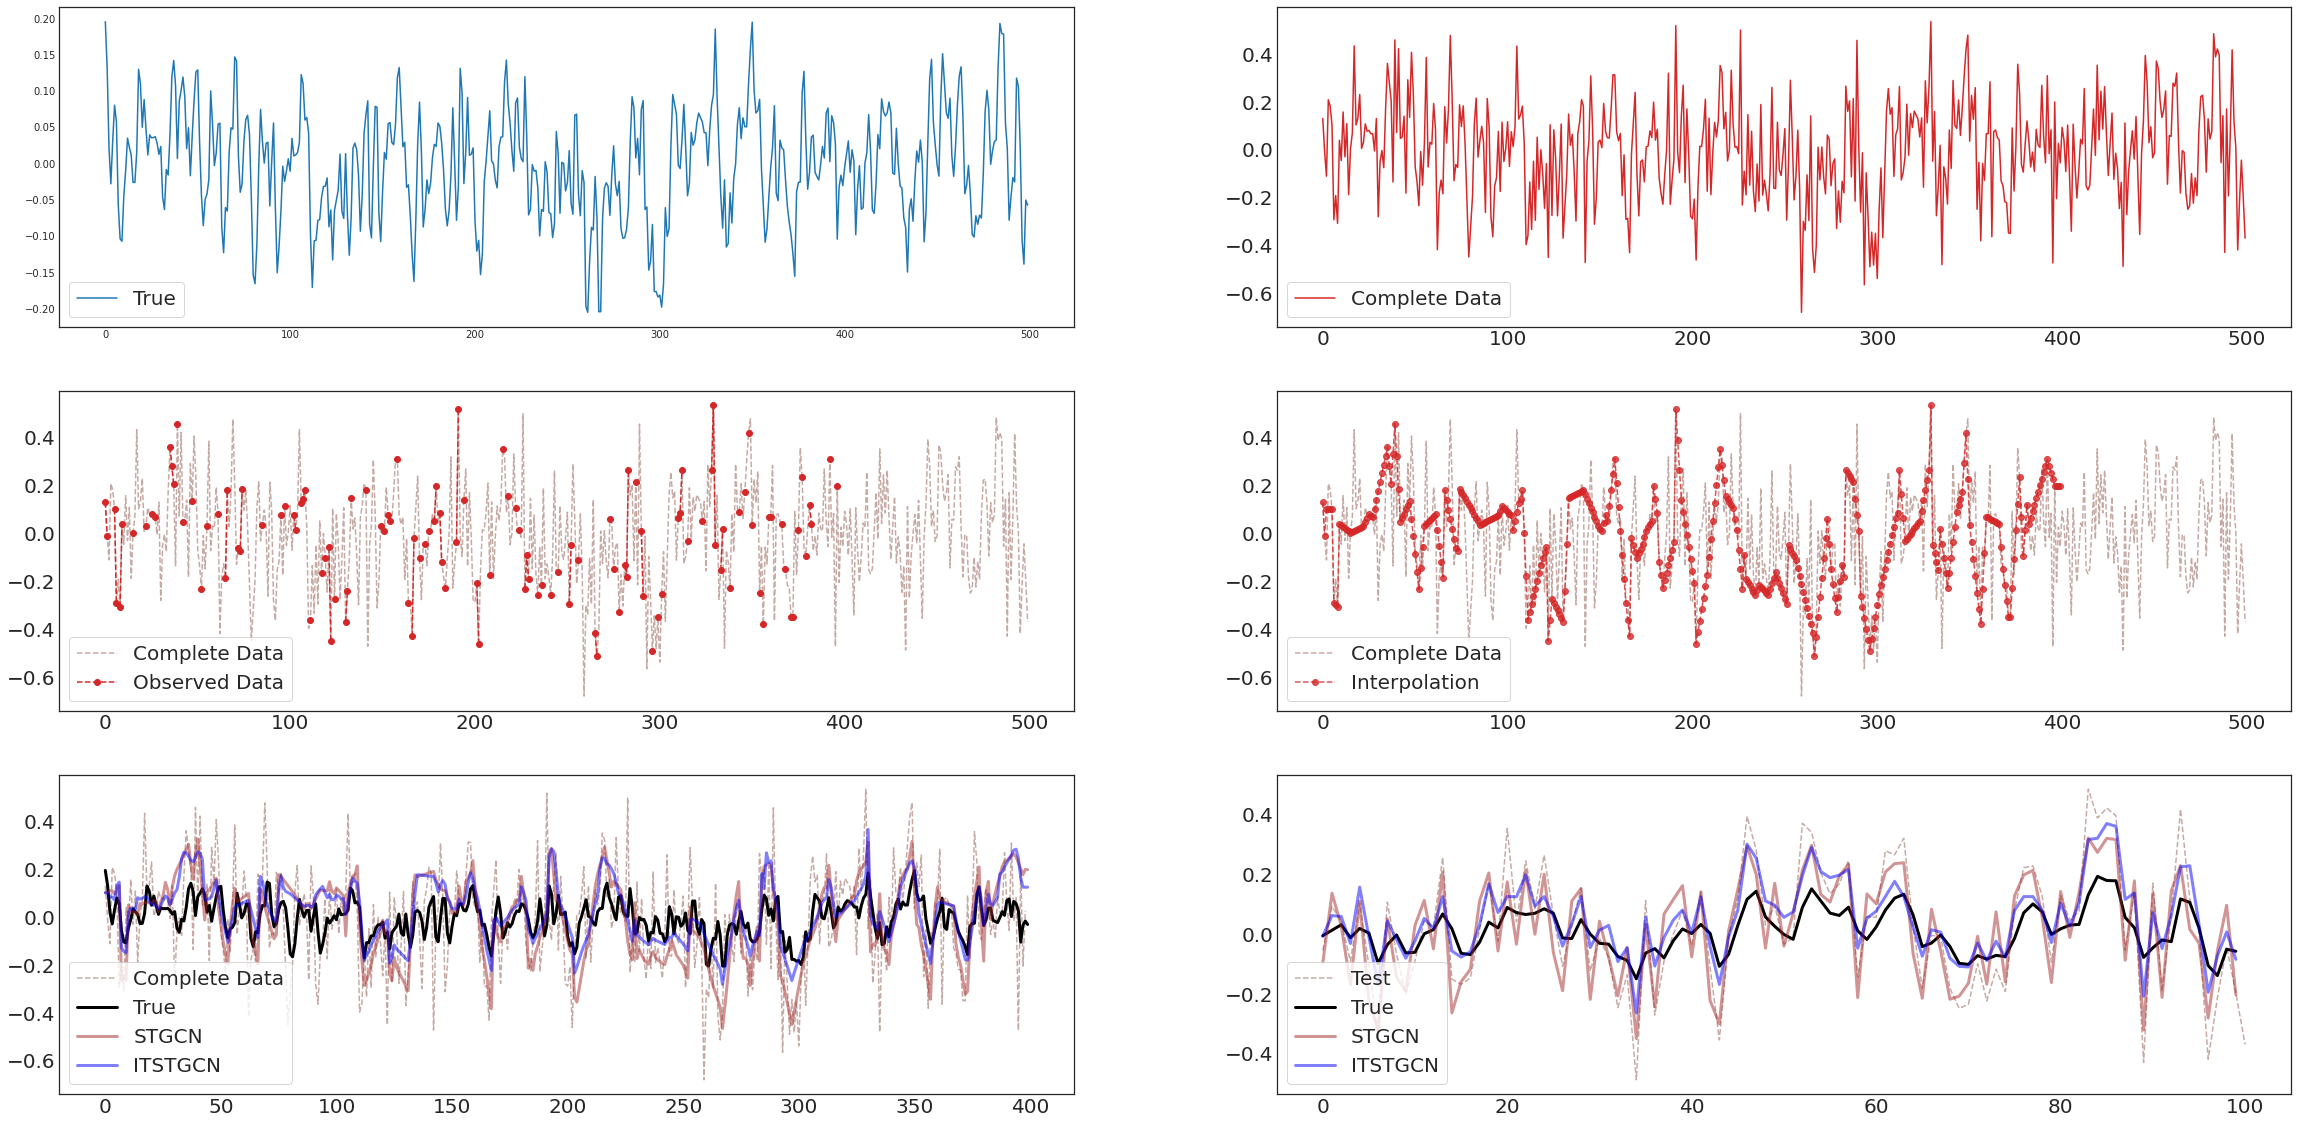

In [41]:
with plt.style.context('seaborn-white'):
    fig, ((ax1, ax2), (ax3, ax4), (ax5,ax6)) = plt.subplots(3, 2,figsize=(40,20))
    # fig.suptitle('Figure 1(node 1)',fontsize=40)
    ax1.plot(a_ar_values_true,label='True')
    ax1.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    
    ax2.plot(np.array(data_dict['FX'])[:,0],'-',color='C3',label='Complete Data')
    ax2.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='x', labelsize=20)
    
    ax3.plot(np.array(data_dict['FX'])[:,0],'--',color='C5',alpha=0.5,label='Complete Data')
    ax3.plot(torch.cat([torch.tensor(dataset.features)[:2,0,0],torch.tensor(train_dataset_miss_rand.targets).reshape(-1,2)[:,0]],dim=0),'--o',color='C3',label='Observed Data')
    ax3.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax3.tick_params(axis='y', labelsize=20)
    ax3.tick_params(axis='x', labelsize=20)
    
    ax4.plot(np.array(data_dict['FX'])[:,0],'--',color='C5',alpha=0.5,label='Complete Data')
    ax4.plot(torch.cat([torch.tensor(dataset.features)[:2,0,0],torch.tensor(train_dataset_padded_rand.targets).reshape(-1,2)[:,0]],dim=0),'--o',color='C3',alpha=0.8,label='Interpolation')
    ax4.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax4.tick_params(axis='y', labelsize=20)
    ax4.tick_params(axis='x', labelsize=20)
    
    ax5.plot(torch.tensor(data_dict['FX'])[:399,0],'--',color='C5',alpha=0.5,label='Complete Data')
    ax5.plot(a_ar_values_true[:400],color='black',label='True',lw=3)
    ax5.plot(evtor_rand.fhat_tr[:,0],color='brown',lw=3,label='STGCN',alpha=0.5)
    ax5.plot(evtor_rand_it.fhat_tr[:,0],color='blue',lw=3,label='ITSTGCN',alpha=0.5)
    # ax4.plot(55, 0, 'o', markersize=100, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    # ax4.plot(150, 0, 'o', markersize=80, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    # ax4.plot(185, 0, 'o', markersize=80, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    ax5.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax5.tick_params(axis='y', labelsize=20)
    ax5.tick_params(axis='x', labelsize=20)
    
    ax6.plot(torch.tensor(data_dict['FX'])[399:,0],'--',color='C5',alpha=0.5,label='Test')
    ax6.plot(a_ar_values_true[400:],color='black',label='True',lw=3)
    ax6.plot(evtor_rand.fhat_test[:,0],color='brown',lw=3,label='STGCN',alpha=0.5)
    ax6.plot(evtor_rand_it.fhat_test[:,0],color='blue',lw=3,label='ITSTGCN',alpha=0.5)
    ax6.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax6.tick_params(axis='y', labelsize=20)
    ax6.tick_params(axis='x', labelsize=20)
# # plt.savefig('try2_node1.png')

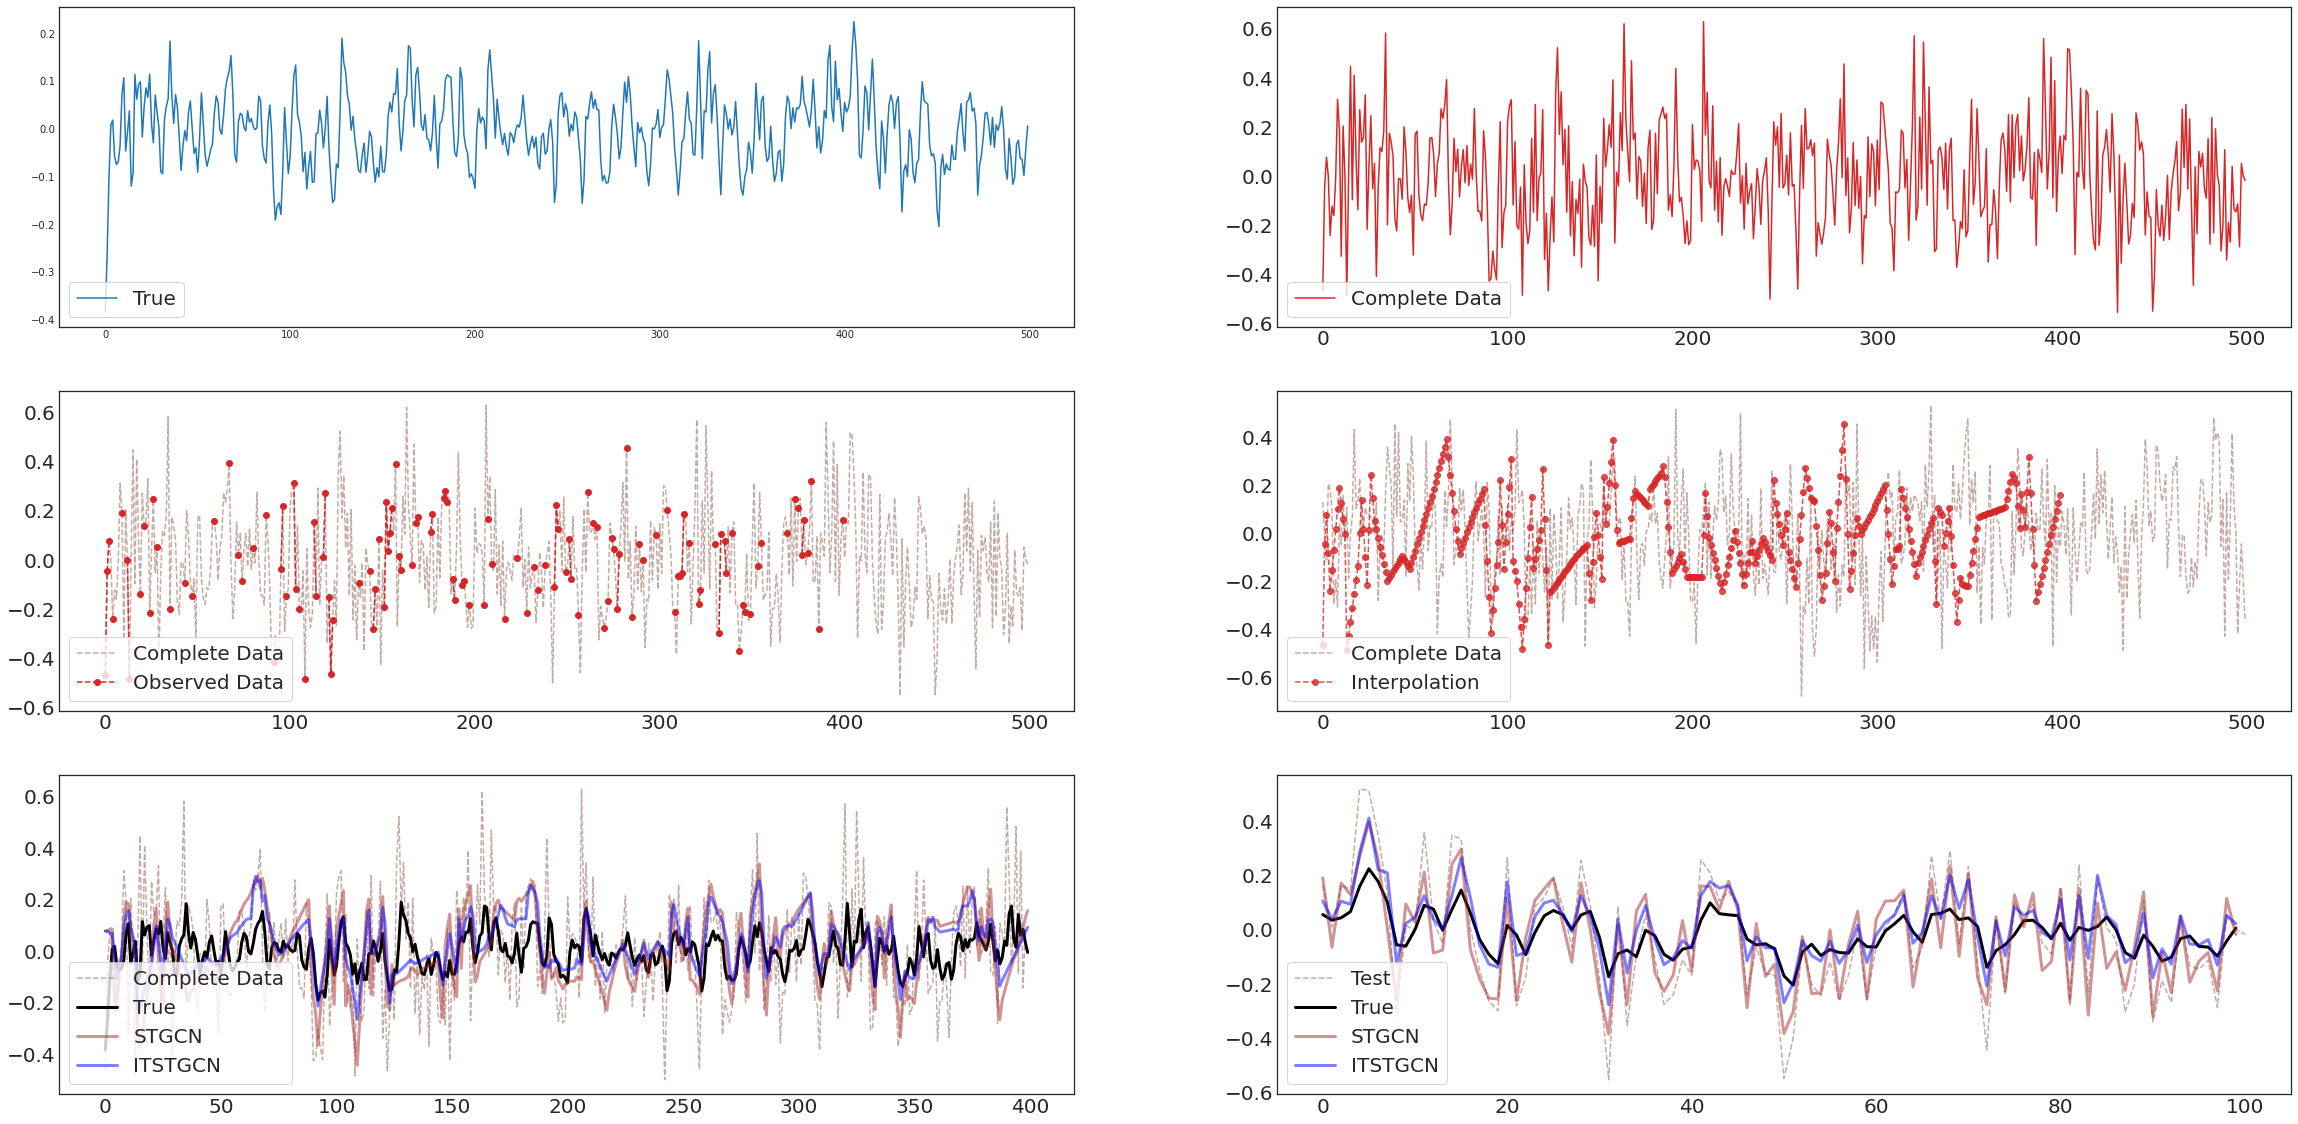

In [42]:
with plt.style.context('seaborn-white'):
    fig, ((ax1, ax2), (ax3, ax4), (ax5,ax6)) = plt.subplots(3, 2,figsize=(40,20))
    # fig.suptitle('Figure 1(node 1)',fontsize=40)
    
    ax1.plot(b_ar_values_true,label='True')
    ax1.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    
    ax2.plot(np.array(data_dict['FX'])[:,1],'-',color='C3',label='Complete Data')
    ax2.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='x', labelsize=20)
    
    ax3.plot(np.array(data_dict['FX'])[:,1],'--',color='C5',alpha=0.5,label='Complete Data')
    ax3.plot(torch.cat([torch.tensor(dataset.features)[:2,1,0],torch.tensor(train_dataset_miss_rand.targets).reshape(-1,2)[:,1]],dim=0),'--o',color='C3',label='Observed Data')
    ax3.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax3.tick_params(axis='y', labelsize=20)
    ax3.tick_params(axis='x', labelsize=20)
    
    ax4.plot(np.array(data_dict['FX'])[:,0],'--',color='C5',alpha=0.5,label='Complete Data')
    ax4.plot(torch.cat([torch.tensor(dataset.features)[:2,1,0],torch.tensor(train_dataset_padded_rand.targets).reshape(-1,2)[:,1]],dim=0),'--o',color='C3',alpha=0.8,label='Interpolation')
    ax4.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax4.tick_params(axis='y', labelsize=20)
    ax4.tick_params(axis='x', labelsize=20)
    
    ax5.plot(torch.tensor(data_dict['FX'])[:399,1],'--',color='C5',alpha=0.5,label='Complete Data')
    ax5.plot(b_ar_values_true[:400],color='black',label='True',lw=3)
    ax5.plot(evtor_rand.fhat_tr[:,1],color='brown',lw=3,label='STGCN',alpha=0.5)
    ax5.plot(evtor_rand_it.fhat_tr[:,1],color='blue',lw=3,label='ITSTGCN',alpha=0.5)
    # ax5.plot(55, 0, 'o', markersize=100, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    # ax5.plot(150, 0, 'o', markersize=80, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    # ax5.plot(185, 0, 'o', markersize=80, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    ax5.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax5.tick_params(axis='y', labelsize=20)
    ax5.tick_params(axis='x', labelsize=20)
    
    ax6.plot(torch.tensor(data_dict['FX'])[399:,1],'--',color='C5',alpha=0.5,label='Test')
    ax6.plot(b_ar_values_true[400:],color='black',label='True',lw=3)
    ax6.plot(evtor_rand.fhat_test[:,1],color='brown',lw=3,label='STGCN',alpha=0.5)
    ax6.plot(evtor_rand_it.fhat_test[:,1],color='blue',lw=3,label='ITSTGCN',alpha=0.5)
    ax6.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax6.tick_params(axis='y', labelsize=20)
    ax6.tick_params(axis='x', labelsize=20)
# # plt.savefig('try2_node1.png')

# Block

In [43]:
data_dict = load_data('toy_ex_dataset.pkl')

In [44]:
loader = itstgcn.DatasetLoader(data_dict)

In [45]:
dataset = loader.get_dataset(lags=2)

In [46]:
train_dataset, test_dataset = itstgcn.temporal_signal_split(dataset, train_ratio=0.8)

In [47]:
mindex_block = [list(range(80,200)),list(range(200,290))]

In [48]:
train_dataset_miss_block = itstgcn.miss(train_dataset,mindex_block,mtype='block')

In [49]:
train_dataset_padded_block = itstgcn.padding(train_dataset_miss_block) # padding(train_dataset_miss,method='linear'와 같음)

`-` 학습

In [50]:
lrnr_block = itstgcn.StgcnLearner(train_dataset_padded_block)

In [ ]:
lrnr_block.learn(filters=32,epoch=50)

In [ ]:
lrnr_block_it = itstgcn.ITStgcnLearner(train_dataset_padded_block)

In [ ]:
lrnr_block_it.learn(filters=32,epoch=50)

`-` 모형 평가 및 시각화

In [ ]:
evtor_block = itstgcn.Evaluator(lrnr_block,train_dataset_padded_block,test_dataset)

In [ ]:
fig = evtor_block.plot('--.',h=5,max_node=2,label='complete data',alpha=0.5) # max_nodes 는 1보다 커야함
fig.set_figwidth(20)
fig.set_figheight(10)
fig.tight_layout()
fig

In [ ]:
evtor_block_it = itstgcn.Evaluator(lrnr_block_it,train_dataset_padded_block,test_dataset)

In [ ]:
fig = evtor_block_it.plot('--.',h=5,max_node=2,label='complete data',alpha=0.5) # max_nodes 는 1보다 커야함
fig.set_figwidth(20)
fig.set_figheight(10)
fig.tight_layout()
fig

In [ ]:
with plt.style.context('seaborn-white'):
    fig, ((ax1, ax2), (ax3, ax4), (ax5,ax6)) = plt.subplots(3, 2,figsize=(40,20))
    # fig.suptitle('Figure 1(node 1)',fontsize=40)
    
    ax1.plot(a_ar_values_true,label='True')
    ax1.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    
    ax2.plot(np.array(data_dict['FX'])[:,0],'-',color='C3',label='Complete Data')
    ax2.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='x', labelsize=20)
    
    ax3.plot(np.array(data_dict['FX'])[:,0],'--',color='C5',alpha=0.5,label='Complete Data')
    ax3.plot(torch.cat([torch.tensor(dataset.features)[:2,0,0],torch.tensor(train_dataset_miss_block.targets).reshape(-1,2)[:,0]],dim=0),'--o',color='C3',label='Observed Data')
    ax3.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax3.tick_params(axis='y', labelsize=20)
    ax3.tick_params(axis='x', labelsize=20)
    
    ax4.plot(np.array(data_dict['FX'])[:,0],'--',color='C5',alpha=0.5,label='Complete Data')
    ax4.plot(torch.cat([torch.tensor(dataset.features)[:2,0,0],torch.tensor(train_dataset_padded_block.targets).reshape(-1,2)[:,0]],dim=0),'--o',color='C3',alpha=0.8,label='Interpolation')
    ax4.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax4.tick_params(axis='y', labelsize=20)
    ax4.tick_params(axis='x', labelsize=20)
    
    ax5.plot(torch.tensor(data_dict['FX'])[:399,0],'--',color='C5',alpha=0.5,label='Complete Data')
    ax5.plot(a_ar_values_true[:400],color='black',label='True',lw=3)
    ax5.plot(evtor_block.fhat_tr[:,0],color='brown',lw=3,label='STGCN',alpha=0.5)
    ax5.plot(evtor_block_it.fhat_tr[:,0],color='blue',lw=3,label='ITSTGCN',alpha=0.5)
    # ax5.plot(55, 0, 'o', markersize=100, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    # ax5.plot(150, 0, 'o', markersize=80, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    # ax5.plot(185, 0, 'o', markersize=80, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    ax5.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax5.tick_params(axis='y', labelsize=20)
    ax5.tick_params(axis='x', labelsize=20)
    
    ax6.plot(torch.tensor(data_dict['FX'])[399:,0],'--',color='C5',alpha=0.5,label='Test')
    ax6.plot(a_ar_values_true[400:],color='black',label='True',lw=3)
    ax6.plot(evtor_block.fhat_test[:,0],color='brown',lw=3,label='STGCN',alpha=0.5)
    ax6.plot(evtor_block_it.fhat_test[:,0],color='blue',lw=3,label='ITSTGCN',alpha=0.5)
    ax6.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax6.tick_params(axis='y', labelsize=20)
    ax6.tick_params(axis='x', labelsize=20)
# # plt.savefig('try2_node1.png')

In [ ]:
with plt.style.context('seaborn-white'):
    fig, ((ax1, ax2), (ax3, ax4), (ax5,ax6)) = plt.subplots(3, 2,figsize=(40,20))
    # fig.suptitle('Figure 1(node 1)',fontsize=40)
    
    ax1.plot(b_ar_values_true,label='True')
    ax1.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    
    ax2.plot(np.array(data_dict['FX'])[:,1],'-',color='C3',label='Complete Data')
    ax2.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='x', labelsize=20)
    
    ax3.plot(np.array(data_dict['FX'])[:,1],'--',color='C5',alpha=0.5,label='Complete Data')
    ax3.plot(torch.cat([torch.tensor(dataset.features)[:2,1,0],torch.tensor(train_dataset_miss_block.targets).reshape(-1,2)[:,1]],dim=0),'--o',color='C3',label='Observed Data')
    ax3.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax3.tick_params(axis='y', labelsize=20)
    ax3.tick_params(axis='x', labelsize=20)
    
    ax4.plot(np.array(data_dict['FX'])[:,0],'--',color='C5',alpha=0.5,label='Complete Data')
    ax4.plot(torch.cat([torch.tensor(dataset.features)[:2,1,0],torch.tensor(train_dataset_padded_block.targets).reshape(-1,2)[:,1]],dim=0),'--o',color='C3',alpha=0.8,label='Interpolation')
    ax4.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax4.tick_params(axis='y', labelsize=20)
    ax4.tick_params(axis='x', labelsize=20)
    
    ax5.plot(torch.tensor(data_dict['FX'])[:399,1],'--',color='C5',alpha=0.5,label='Complete Data')
    ax5.plot(b_ar_values_true[:400],color='black',label='True',lw=3)
    ax5.plot(evtor_block.fhat_tr[:,1],color='brown',lw=3,label='STGCN',alpha=0.5)
    ax5.plot(evtor_block_it.fhat_tr[:,1],color='blue',lw=3,label='ITSTGCN',alpha=0.5)
    # ax5.plot(55, 0, 'o', markersize=100, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    # ax5.plot(150, 0, 'o', markersize=80, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    # ax5.plot(185, 0, 'o', markersize=80, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    ax5.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax5.tick_params(axis='y', labelsize=20)
    ax5.tick_params(axis='x', labelsize=20)
    
    ax6.plot(torch.tensor(data_dict['FX'])[399:,1],'--',color='C5',alpha=0.5,label='Test')
    ax6.plot(b_ar_values_true[400:],color='black',label='True',lw=3)
    ax6.plot(evtor_block.fhat_test[:,1],color='brown',lw=3,label='STGCN',alpha=0.5)
    ax6.plot(evtor_block_it.fhat_test[:,1],color='blue',lw=3,label='ITSTGCN',alpha=0.5)
    ax6.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax6.tick_params(axis='y', labelsize=20)
    ax6.tick_params(axis='x', labelsize=20)
# # plt.savefig('try2_node1.png')

# Random & Block

In [ ]:
data_dict = load_data('toy_ex_dataset.pkl')

In [ ]:
loader = itstgcn.DatasetLoader(data_dict)

In [ ]:
dataset = loader.get_dataset(lags=2)

In [ ]:
train_dataset, test_dataset = itstgcn.temporal_signal_split(dataset, train_ratio=0.8)

In [ ]:
mindex_rdbl = [random.sample(range(0, 400), int(400*0.5)),[np.array(list(range(150,220)))]]

In [ ]:
train_dataset_miss_rdbl = itstgcn.miss(train_dataset,mindex_rdbl,mtype='block')

In [ ]:
train_dataset_padded_rdbl = itstgcn.padding(train_dataset_miss_rdbl) # padding(train_dataset_miss,method='linear'와 같음)

`-` 학습

In [ ]:
lrnr_rdbl = itstgcn.StgcnLearner(train_dataset_padded_rdbl)

In [ ]:
lrnr_rdbl.learn(filters=32,epoch=50)

In [ ]:
lrnr_rdbl_it = itstgcn.ITStgcnLearner(train_dataset_padded_rdbl)

In [ ]:
lrnr_rdbl_it.learn(filters=32,epoch=50)

`-` 모형 평가 및 시각화

In [ ]:
evtor_rdbl = itstgcn.Evaluator(lrnr_rdbl,train_dataset_padded_rdbl,test_dataset)

In [ ]:
fig = evtor_rdbl.plot('--.',h=5,max_node=2,label='complete data',alpha=0.5) # max_nodes 는 1보다 커야함
fig.set_figwidth(20)
fig.set_figheight(10)
fig.tight_layout()
fig

In [ ]:
evtor_rdbl_it = itstgcn.Evaluator(lrnr_rdbl_it,train_dataset_padded_rdbl,test_dataset)

In [ ]:
fig = evtor_rdbl_it.plot('--.',h=5,max_node=2,label='complete data',alpha=0.5) # max_nodes 는 1보다 커야함
fig.set_figwidth(20)
fig.set_figheight(10)
fig.tight_layout()
fig

In [ ]:
with plt.style.context('seaborn-white'):
    fig, ((ax1, ax2), (ax3, ax4), (ax5,ax6)) = plt.subplots(3, 2,figsize=(40,20))
    # fig.suptitle('Figure 1(node 1)',fontsize=40)
    
    ax1.plot(a_ar_values_true,label='True')
    ax1.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    
    ax2.plot(np.array(data_dict['FX'])[:,0],'-',color='C3',label='Complete Data')
    ax2.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='x', labelsize=20)
    
    ax3.plot(np.array(data_dict['FX'])[:,0],'--',color='C5',alpha=0.5,label='Complete Data')
    ax3.plot(torch.cat([torch.tensor(dataset.features)[:2,0,0],torch.tensor(train_dataset_miss_rdbl.targets).reshape(-1,2)[:,0]],dim=0),'--o',color='C3',label='Observed Data')
    ax3.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax3.tick_params(axis='y', labelsize=20)
    ax3.tick_params(axis='x', labelsize=20)
    
    ax4.plot(np.array(data_dict['FX'])[:,0],'--',color='C5',alpha=0.5,label='Complete Data')
    ax4.plot(torch.cat([torch.tensor(dataset.features)[:2,0,0],torch.tensor(train_dataset_padded_rdbl.targets).reshape(-1,2)[:,0]],dim=0),'--o',color='C3',alpha=0.8,label='Interpolation')
    ax4.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax4.tick_params(axis='y', labelsize=20)
    ax4.tick_params(axis='x', labelsize=20)
    
    ax5.plot(torch.tensor(data_dict['FX'])[:399,0],'--',color='C5',alpha=0.5,label='Complete Data')
    ax5.plot(a_ar_values_true[:400],color='black',label='True',lw=3)
    ax5.plot(evtor_rdbl.fhat_tr[:,0],color='brown',lw=3,label='STGCN',alpha=0.5)
    ax5.plot(evtor_rdbl_it.fhat_tr[:,0],color='blue',lw=3,label='ITSTGCN',alpha=0.5)
    # ax5.plot(55, 0, 'o', markersize=100, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    # ax5.plot(150, 0, 'o', markersize=80, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    # ax5.plot(185, 0, 'o', markersize=80, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    ax5.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax5.tick_params(axis='y', labelsize=20)
    ax5.tick_params(axis='x', labelsize=20)
    
    ax6.plot(torch.tensor(data_dict['FX'])[399:,0],'--',color='C5',alpha=0.5,label='Test')
    ax6.plot(a_ar_values_true[400:],color='black',label='True',lw=3)
    ax6.plot(evtor_rdbl.fhat_test[:,0],color='brown',lw=3,label='STGCN',alpha=0.5)
    ax6.plot(evtor_rdbl_it.fhat_test[:,0],color='blue',lw=3,label='ITSTGCN',alpha=0.5)
    ax6.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax6.tick_params(axis='y', labelsize=20)
    ax6.tick_params(axis='x', labelsize=20)
# # plt.savefig('try2_node1.png')

In [ ]:
with plt.style.context('seaborn-white'):
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2,figsize=(40,20))
    # fig.suptitle('Figure 1(node 1)',fontsize=40)
    
    ax1.plot(b_ar_values_true,label='True')
    ax1.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    
    ax2.plot(np.array(data_dict['FX'])[:,1],'-',color='C3',label='Complete Data')
    ax2.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='x', labelsize=20)
    
    ax3.plot(np.array(data_dict['FX'])[:,1],'--',color='C5',alpha=0.5,label='Complete Data')
    ax3.plot(torch.cat([torch.tensor(dataset.features)[:2,1,0],torch.tensor(train_dataset_miss_rand.targets).reshape(-1,2)[:,1]],dim=0),'--o',color='C3',label='Observed Data')
    ax3.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax3.tick_params(axis='y', labelsize=20)
    ax3.tick_params(axis='x', labelsize=20)
    
    ax4.plot(np.array(data_dict['FX'])[:,0],'--',color='C5',alpha=0.5,label='Complete Data')
    ax4.plot(torch.cat([torch.tensor(dataset.features)[:2,1,0],torch.tensor(train_dataset_padded_rdbl.targets).reshape(-1,2)[:,1]],dim=0),'--o',color='C3',alpha=0.8,label='Interpolation')
    ax4.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax4.tick_params(axis='y', labelsize=20)
    ax4.tick_params(axis='x', labelsize=20)
    
    ax5.plot(torch.tensor(data_dict['FX'])[:399,1],'--',color='C5',alpha=0.5,label='Complete Data')
    ax5.plot(b_ar_values_true[:400],color='black',label='True',lw=3)
    ax5.plot(evtor_rdbl.fhat_tr[:,1],color='brown',lw=3,label='STGCN',alpha=0.5)
    ax5.plot(evtor_rdbl_it.fhat_tr[:,1],color='blue',lw=3,label='ITSTGCN',alpha=0.5)
    # ax5.plot(55, 0, 'o', markersize=100, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    # ax5.plot(150, 0, 'o', markersize=80, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    # ax5.plot(185, 0, 'o', markersize=80, markerfacecolor='none', markeredgecolor='red',markeredgewidth=3)
    ax5.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax5.tick_params(axis='y', labelsize=20)
    ax5.tick_params(axis='x', labelsize=20)
    
    ax6.plot(torch.tensor(data_dict['FX'])[399:,1],'--',color='C5',alpha=0.5,label='Test')
    ax6.plot(b_ar_values_true[400:],color='black',label='True',lw=3)
    ax6.plot(evtor_rdbl.fhat_test[:,1],color='brown',lw=3,label='STGCN',alpha=0.5)
    ax6.plot(evtor_rdbl_it.fhat_test[:,1],color='blue',lw=3,label='ITSTGCN',alpha=0.5)
    ax6.legend(fontsize=20,loc='lower left',facecolor='white', frameon=True)
    ax6.tick_params(axis='y', labelsize=20)
    ax6.tick_params(axis='x', labelsize=20)
# # plt.savefig('try2_node1.png')